In [1]:
import json
from src.model.model import BasicXGBOOST1
from pipeline import run
import polars  as pl
import numpy as np

In [2]:
X_test, y_test, times_test = run()

100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


(122571, 8300) (122571,) (122571, 100)
Fitting model


/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Accuracy: 0.7915561900877014
Model saved to saved_models/model_xgboost1.json


In [3]:
model_path = 'saved_models/model_xgboost1.json'

model = BasicXGBOOST1()
model.init_model()
model.load(model_path)

Model loaded from saved_models/model_xgboost1.json


In [30]:
df =  pl.from_numpy(times_test).cast(pl.Datetime("ns","UTC"))
newest_times = np.argsort( times_test, axis=0)
print(newest_times)

[[ 4300  4300  4300 ...  4300  4300  4300]
 [ 4611  4611  4611 ...  4611  4611  4611]
 [  262   262   262 ...   262   262   262]
 ...
 [ 3919  3919  3919 ...  3919  3919  3919]
 [21267 21267 21267 ... 17983 17983 17983]
 [17983 17983 17983 ... 21267 21267 21267]]


In [32]:
X_test_newest = X_test[newest_times[:,0]]
y_test_newest = y_test[newest_times[:,0]]
times_test_newest = times_test[newest_times[:,0]]
times_test_newest_datetime = pl.from_numpy(times_test_newest[:,0]).cast(pl.Datetime("ns","UTC"))

print(X_test_newest.shape, y_test_newest.shape, times_test_newest.shape, times_test_newest_datetime.shape)

(24515, 8300) (24515,) (24515, 100) (24515, 1)


In [35]:
y_model = model.predict(X_test_newest)

In [58]:
correctness = np.equal(y_model,y_test_newest).astype(int)
accuracy_cum = np.cumsum(correctness)/np.arange(1,len(correctness)+1)
accuracy_ma_100 = np.expand_dims(np.convolve(correctness, np.ones(100)/100, mode='valid'),axis=1)
accuracy_ma_1000 = np.expand_dims(np.convolve(correctness, np.ones(1000)/1000, mode='valid'),axis=1)


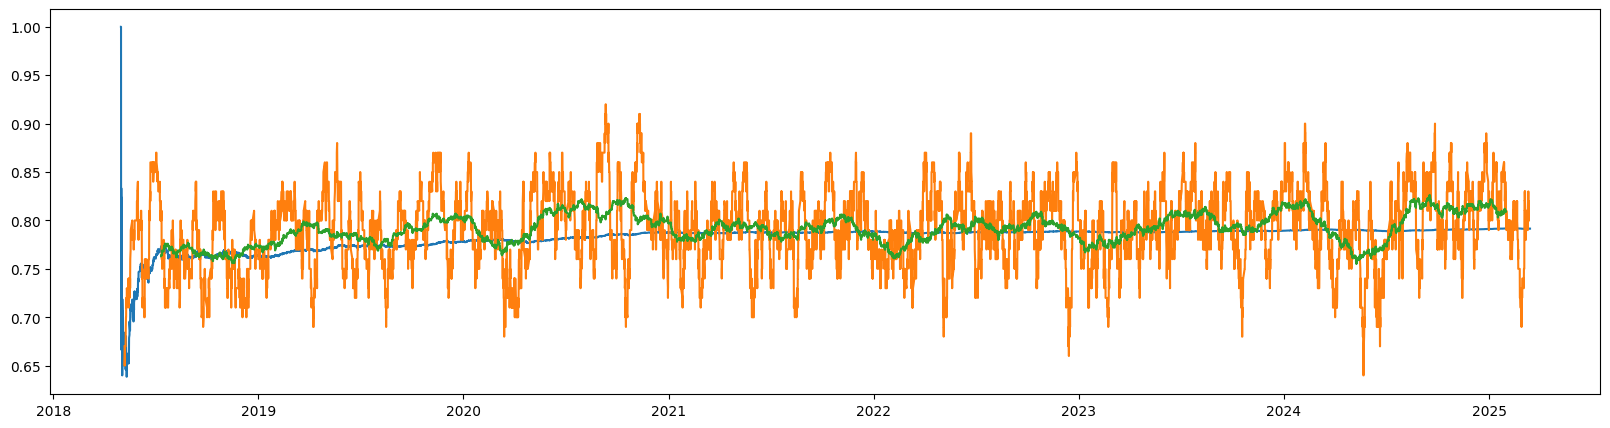

In [59]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,5))
plt.plot(times_test_newest_datetime, accuracy_cum, label='Cum')
plt.plot(times_test_newest_datetime[50:50+len(accuracy_ma_100)], accuracy_ma_100, label='MA')
plt.plot(times_test_newest_datetime[500:500+len(accuracy_ma_1000)], accuracy_ma_1000, label='MA')
plt.show()